# Comprehensive Fraud Detection System

## Dual-System Approach for Cross-Border Transaction Analysis

This notebook implements a sophisticated fraud detection system with two complementary approaches:

### System 1: Legitimate Transaction Profiler
- Identifies patterns that indicate legitimate transactions
- Rule-based system with statistical analysis
- Focuses on normal transaction behaviors

### System 2: Fraud Detection Engine  
- Actively detects suspicious patterns and fraudulent activities
- Machine Learning models with anomaly detection
- Identifies high-risk transaction patterns

The idea is rather then instantly assuming smth is guilty => we use an "innocent until proven guilty mentality"
- This frees up much needed computational power => rather then analysing all the transaction for fraud we analyse those that are not legit
- acts as a natural escalator, normal => suspicious => guilty

### Dataset Overview
- **Is_laundering**: 0 = Normal, 1 = Fraudulent
- **Features**: Time, Date, Accounts, Amount, Currencies, Locations, Payment Types
- **Laundering Types**: Smurfing, Structuring, Cash_Withdrawal, Behavioural_Change, etc.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("✓ SMOTE and LightGBM ready for hierarchical classification")

print("Libraries imported successfully!")


Libraries imported successfully!
✓ SMOTE and LightGBM ready for hierarchical classification
Libraries imported successfully!


In [3]:
# Load and explore the dataset
print("Loading dataset...")
df = pd.read_csv('data/SAML-D.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())


Loading dataset...
Dataset shape: (9504852, 12)
Columns: ['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Is_laundering', 'Laundering_type']

First few rows:
       Time        Date  Sender_account  Receiver_account    Amount  \
0  10:35:19  2022-10-07      8724731955        2769355426   1459.15   
1  10:35:20  2022-10-07      1491989064        8401255335   6019.64   
2  10:35:20  2022-10-07       287305149        4404767002  14328.44   
3  10:35:21  2022-10-07      5376652437        9600420220  11895.00   
4  10:35:21  2022-10-07      9614186178        3803336972    115.25   

  Payment_currency Received_currency Sender_bank_location  \
0        UK pounds         UK pounds                   UK   
1        UK pounds            Dirham                   UK   
2        UK pounds         UK pounds                   UK   
3        UK pounds         UK pounds           

=== DATA QUALITY ANALYSIS ===
Missing values per column:
Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64

Fraud distribution:
Normal transactions (0): 9,494,979 (99.90%)
Fraudulent transactions (1): 9,873 (0.10%)

Laundering types distribution:
Laundering_type
Normal_Small_Fan_Out      3477717
Normal_Fan_Out            2302220
Normal_Fan_In             2104285
Normal_Group               528351
Normal_Cash_Withdrawal     305031
Normal_Cash_Deposits       223801
Normal_Periodical          210526
Normal_Plus_Mutual         155041
Normal_Mutual              125335
Normal_Foward               42031
Normal_single_large         20641
Structuring                  1870
Cash_Withdrawal              1

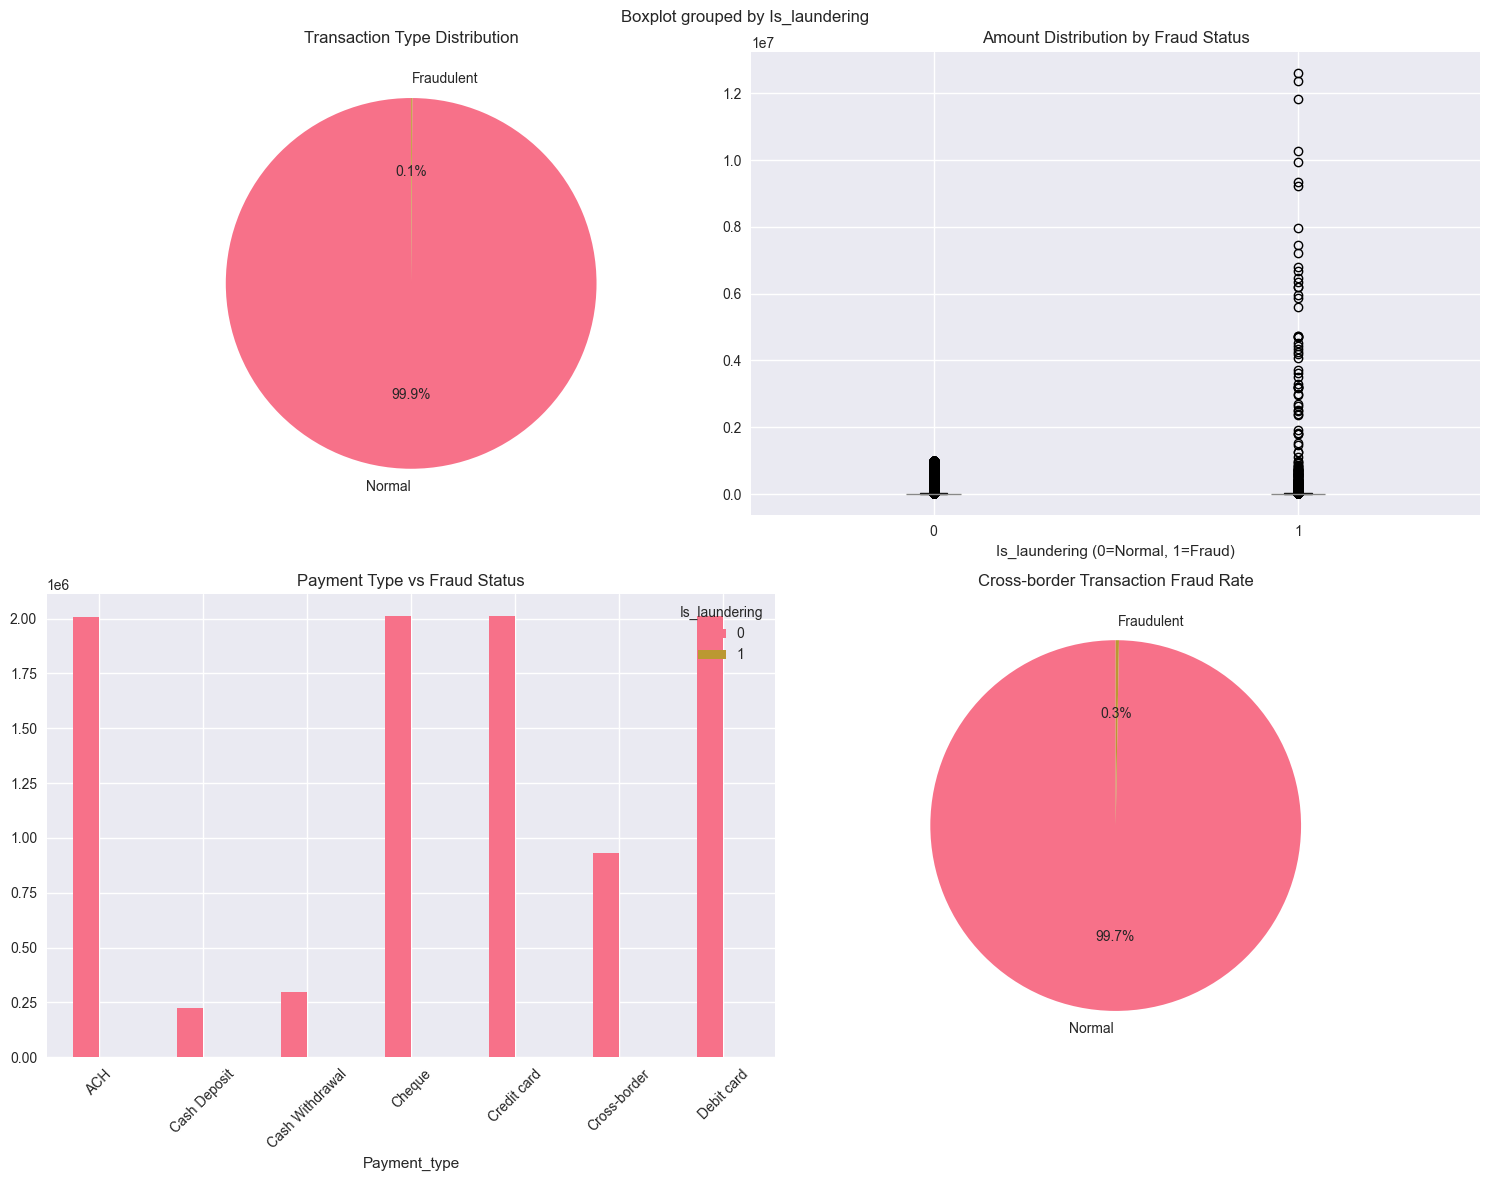

In [4]:
# Data Quality and Distribution Analysis
print("=== DATA QUALITY ANALYSIS ===")
print(f"Missing values per column:")
print(df.isnull().sum())

print(f"\nFraud distribution:")
fraud_counts = df['Is_laundering'].value_counts()
print(f"Normal transactions (0): {fraud_counts[0]:,} ({fraud_counts[0]/len(df)*100:.2f}%)")
print(f"Fraudulent transactions (1): {fraud_counts[1]:,} ({fraud_counts[1]/len(df)*100:.2f}%)")

print(f"\nLaundering types distribution:")
print(df['Laundering_type'].value_counts())

# Visualize fraud distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Fraud distribution
axes[0,0].pie(fraud_counts.values, labels=['Normal', 'Fraudulent'], autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Transaction Type Distribution')

# Amount distribution by fraud status
df.boxplot(column='Amount', by='Is_laundering', ax=axes[0,1])
axes[0,1].set_title('Amount Distribution by Fraud Status')
axes[0,1].set_xlabel('Is_laundering (0=Normal, 1=Fraud)')

# Payment type distribution
payment_fraud = df.groupby(['Payment_type', 'Is_laundering']).size().unstack()
payment_fraud.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Payment Type vs Fraud Status')
axes[1,0].tick_params(axis='x', rotation=45)

# Cross-border transactions
cross_border = df[df['Payment_type'] == 'Cross-border']
if len(cross_border) > 0:
    cross_border_fraud = cross_border['Is_laundering'].value_counts()
    axes[1,1].pie(cross_border_fraud.values, labels=['Normal', 'Fraudulent'], autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Cross-border Transaction Fraud Rate')
else:
    axes[1,1].text(0.5, 0.5, 'No Cross-border transactions', ha='center', va='center')
    axes[1,1].set_title('Cross-border Transactions')

plt.tight_layout()
plt.show()


In [4]:
# Feature Engineering for Enhanced Detection
print("=== FEATURE ENGINEERING ===")

# Create a copy for feature engineering
df_features = df.copy()

RISKY_COUNTRIES = ['Nigeria', 'Mexico', 'India']

# 1. Time-based features
df_features['Time'] = pd.to_datetime(df_features['Time'], format='%H:%M:%S')
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_features['Hour'] = df_features['Time'].dt.hour
df_features['Day_of_week'] = df_features['Date'].dt.dayofweek
df_features['Month'] = df_features['Date'].dt.month

# 2. Amount-based features
df_features['Amount_log'] = np.log1p(df_features['Amount'])
df_features['Amount_zscore'] = (df_features['Amount'] - df_features['Amount'].mean()) / df_features['Amount'].std()

# 3. Cross-border and currency features
df_features['Is_cross_border'] = (df_features['Sender_bank_location'] != df_features['Receiver_bank_location']).astype(int)
df_features['Is_currency_different'] = (df_features['Payment_currency'] != df_features['Received_currency']).astype(int)
df_features['Is_high_risk_country'] = df_features['Receiver_bank_location'].isin(RISKY_COUNTRIES).astype(int)

# 5. Payment type risk scoring
payment_risk_scores = {
    'Cash Deposit': 0.3,
    'Cash Withdrawal': 0.8,
    'Cross-border': 0.7,
    'Credit card': 0.2,
    'Debit card': 0.2,
    'ACH': 0.1,
    'Cheque': 0.4
}
df_features['Payment_risk_score'] = df_features['Payment_type'].map(payment_risk_scores).fillna(0.5)

# 6. Amount risk categories
df_features['Amount_category'] = pd.cut(df_features['Amount'], 
                                       bins=[0, 1000, 5000, 10000, 50000, float('inf')], 
                                       labels=['Low', 'Medium', 'High', 'Very_High', 'Extreme'])

print("Feature engineering completed!")
print(f"New features added: {[col for col in df_features.columns if col not in df.columns]}")
print(f"Total features: {len(df_features.columns)}")


=== FEATURE ENGINEERING ===
Feature engineering completed!
New features added: ['Hour', 'Day_of_week', 'Month', 'Amount_log', 'Amount_zscore', 'Is_cross_border', 'Is_currency_different', 'Is_high_risk_country', 'Payment_risk_score', 'Amount_category']
Total features: 22


## System 1: Legitimate Transaction Profiler

This system identifies patterns that indicate legitimate transactions using rule-based approaches and statistical analysis.


In [5]:
# System 1: Legitimate Transaction Profiler with Auto-Learning Weights (OPTIMIZED)
class LegitimateTransactionProfiler:
    def __init__(self, weights=None):
        """
        Initialize profiler with optional manual weights
        
        Args:
            weights: Dictionary with keys ['amount', 'timing', 'payment_type', 'currency', 'location']
                    If None, weights will be learned from data automatically
        """
        self.legitimate_patterns = {}
        self.normal_amount_stats = {}
        self.normal_timing_stats = {}
        self.weights = weights  # Can be None (auto-learn) or dict (manual)
        self.weight_learning_method = 'manual' if weights else 'learned'
        
    def analyze_legitimate_patterns(self, df, learn_weights=True):
        """
        Analyze patterns in legitimate transactions and optionally learn weights
        
        Args:
            df: DataFrame with transaction data
            learn_weights: If True and weights=None, learn optimal weights from data
        """
        legitimate_df = df[df['Is_laundering'] == 0]
        
        # 1. Normal amount patterns
        self.normal_amount_stats = {
            'mean': legitimate_df['Amount'].mean(),
            'std': legitimate_df['Amount'].std(),
            'median': legitimate_df['Amount'].median(),
            'q25': legitimate_df['Amount'].quantile(0.25),
            'q75': legitimate_df['Amount'].quantile(0.75)
        }
        
        # 2. Normal timing patterns
        self.normal_timing_stats = {
            'common_hours': legitimate_df['Hour'].mode().tolist(),
            'common_days': legitimate_df['Day_of_week'].mode().tolist(),
            'avg_hour': legitimate_df['Hour'].mean()
        }
        
        # 3. Legitimate payment type patterns
        self.legitimate_patterns['payment_types'] = legitimate_df['Payment_type'].value_counts(normalize=True).to_dict()
        
        # 4. Legitimate currency patterns
        self.legitimate_patterns['currency_combinations'] = legitimate_df.groupby(['Payment_currency', 'Received_currency']).size().to_dict()
        
        # 5. Legitimate location patterns
        self.legitimate_patterns['location_combinations'] = legitimate_df.groupby(['Sender_bank_location', 'Receiver_bank_location']).size().to_dict()
        
        # 6. Learn weights automatically if not provided
        if self.weights is None and learn_weights:
            print("  ⚙️ No manual weights provided - learning optimal weights from data...")
            self._learn_optimal_weights(df)
            self.weight_learning_method = 'learned'
        elif self.weights is None:
            # Use default weights if learning is disabled
            self.weights = {
                'amount': 0.30,
                'timing': 0.25,
                'payment_type': 0.20,
                'currency': 0.15,
                'location': 0.10
            }
            self.weight_learning_method = 'default'
        
        return self.legitimate_patterns
    
    def _learn_optimal_weights(self, df):
        """Learn optimal weights from data using Logistic Regression (VECTORIZED)"""
        from sklearn.linear_model import LogisticRegression
        
        # Calculate component scores VECTORIZED (much faster!)
        X = self._calculate_component_scores_vectorized(df)
        y = (df['Is_laundering'] == 0).astype(int)  # 1 for legitimate, 0 for fraud
        
        # Train logistic regression to learn weights
        lr = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')
        lr.fit(X, y)
        
        # Extract and normalize weights (use absolute values)
        raw_weights = np.abs(lr.coef_[0])
        normalized_weights = raw_weights / raw_weights.sum()
        
        self.weights = {
            'amount': normalized_weights[0],
            'timing': normalized_weights[1],
            'payment_type': normalized_weights[2],
            'currency': normalized_weights[3],
            'location': normalized_weights[4]
        }
        
        print(f"  ✓ Learned weights from data:")
        for feature, weight in self.weights.items():
            print(f"      {feature:15s}: {weight:.3f} ({weight*100:.1f}%)")
    
    def _calculate_component_scores_vectorized(self, df):
        """Calculate component scores using vectorized operations (MUCH FASTER!)"""
        n_samples = len(df)
        component_scores = np.zeros((n_samples, 5))
        
        # 1. Amount score (vectorized)
        q25, q75 = self.normal_amount_stats['q25'], self.normal_amount_stats['q75']
        amount = df['Amount'].values
        
        # Default: 0.3 for all
        component_scores[:, 0] = 0.3
        # Medium range: 0.7
        medium_mask = (amount >= q25 * 0.5) & (amount <= q75 * 2)
        component_scores[medium_mask, 0] = 0.7
        # Perfect range: 1.0
        perfect_mask = (amount >= q25) & (amount <= q75)
        component_scores[perfect_mask, 0] = 1.0
        
        # 2. Timing score (vectorized)
        hours = df['Hour'].values
        avg_hour = self.normal_timing_stats['avg_hour']
        common_hours = set(self.normal_timing_stats['common_hours'])
        
        # Default: 0.4
        component_scores[:, 1] = 0.4
        # Within 3 hours of average: 0.7
        close_mask = np.abs(hours - avg_hour) <= 3
        component_scores[close_mask, 1] = 0.7
        # Exact common hours: 1.0
        exact_mask = df['Hour'].isin(common_hours).values
        component_scores[exact_mask, 1] = 1.0
        
        # 3. Payment type score (vectorized with map)
        payment_types = df['Payment_type'].values
        payment_map = {k: min(v * 10, 1.0) for k, v in self.legitimate_patterns['payment_types'].items()}
        component_scores[:, 2] = np.array([payment_map.get(pt, 0.2) for pt in payment_types])
        
        # 4. Currency score (vectorized with map)
        currency_pairs = list(zip(df['Payment_currency'], df['Received_currency']))
        currency_map = {k: min(v / 1000, 1.0) for k, v in self.legitimate_patterns['currency_combinations'].items()}
        component_scores[:, 3] = np.array([currency_map.get(pair, 0.3) for pair in currency_pairs])
        
        # 5. Location score (vectorized with map)
        location_pairs = list(zip(df['Sender_bank_location'], df['Receiver_bank_location']))
        location_map = {k: min(v / 1000, 1.0) for k, v in self.legitimate_patterns['location_combinations'].items()}
        component_scores[:, 4] = np.array([location_map.get(pair, 0.4) for pair in location_pairs])
        
        return component_scores
    
    def _calculate_component_scores(self, transaction):
        """Calculate individual component scores for a single transaction (for single predictions)"""
        scores = []
        
        # 1. Amount score
        if self.normal_amount_stats['q25'] <= transaction['Amount'] <= self.normal_amount_stats['q75']:
            amount_score = 1.0
        elif self.normal_amount_stats['q25'] * 0.5 <= transaction['Amount'] <= self.normal_amount_stats['q75'] * 2:
            amount_score = 0.7
        else:
            amount_score = 0.3
        scores.append(amount_score)
        
        # 2. Timing score
        if transaction['Hour'] in self.normal_timing_stats['common_hours']:
            timing_score = 1.0
        elif abs(transaction['Hour'] - self.normal_timing_stats['avg_hour']) <= 3:
            timing_score = 0.7
        else:
            timing_score = 0.4
        scores.append(timing_score)
        
        # 3. Payment type score
        payment_type = transaction['Payment_type']
        if payment_type in self.legitimate_patterns['payment_types']:
            payment_score = min(self.legitimate_patterns['payment_types'][payment_type] * 10, 1.0)
        else:
            payment_score = 0.2
        scores.append(payment_score)
        
        # 4. Currency score
        currency_key = (transaction['Payment_currency'], transaction['Received_currency'])
        if currency_key in self.legitimate_patterns['currency_combinations']:
            currency_score = min(self.legitimate_patterns['currency_combinations'][currency_key] / 1000, 1.0)
        else:
            currency_score = 0.3
        scores.append(currency_score)
        
        # 5. Location score
        location_key = (transaction['Sender_bank_location'], transaction['Receiver_bank_location'])
        if location_key in self.legitimate_patterns['location_combinations']:
            location_score = min(self.legitimate_patterns['location_combinations'][location_key] / 1000, 1.0)
        else:
            location_score = 0.4
        scores.append(location_score)
        
        return scores
    
    def calculate_legitimacy_score(self, transaction):
        """Calculate a legitimacy score for a single transaction"""
        # Get component scores
        component_scores = self._calculate_component_scores(transaction)
        
        # Apply weights
        weights_list = [
            self.weights['amount'],
            self.weights['timing'],
            self.weights['payment_type'],
            self.weights['currency'],
            self.weights['location']
        ]
        
        # Calculate weighted score
        final_score = sum(score * weight for score, weight in zip(component_scores, weights_list))
        
        return final_score
    
    def predict_legitimate(self, df):
        """Predict legitimacy scores for all transactions (VECTORIZED - MUCH FASTER!)"""
        # Calculate component scores for all rows at once
        component_scores = self._calculate_component_scores_vectorized(df)
        
        # Create weight vector
        weights_vector = np.array([
            self.weights['amount'],
            self.weights['timing'],
            self.weights['payment_type'],
            self.weights['currency'],
            self.weights['location']
        ])
        
        # Matrix multiplication: much faster than looping!
        # Shape: (n_samples, 5) @ (5,) = (n_samples,)
        final_scores = component_scores @ weights_vector
        
        return final_scores
    
    def get_weight_info(self):
        """Get information about the weights being used"""
        return {
            'method': self.weight_learning_method,
            'weights': self.weights,
            'description': {
                'manual': 'User-provided weights',
                'learned': 'Automatically learned from data using Logistic Regression',
                'default': 'Default weights (no learning performed)'
            }[self.weight_learning_method]
        }

# Initialize and train the legitimate transaction profiler
print("Training Legitimate Transaction Profiler...")
print("-" * 60)

# OPTION 1: Auto-learn weights (recommended - no weights parameter)
profiler = LegitimateTransactionProfiler()  # weights=None by default
legitimate_patterns = profiler.analyze_legitimate_patterns(df_features, learn_weights=True)

# OPTION 2: Use manual weights (uncomment to use)
# manual_weights = {
#     'amount': 0.35,
#     'timing': 0.20,
#     'payment_type': 0.25,
#     'currency': 0.10,
#     'location': 0.10
# }
# profiler = LegitimateTransactionProfiler(weights=manual_weights)
# legitimate_patterns = profiler.analyze_legitimate_patterns(df_features)

print("\nLegitimate patterns identified:")
print(f"  Normal amount range: ${profiler.normal_amount_stats['q25']:.2f} - ${profiler.normal_amount_stats['q75']:.2f}")
print(f"  Common transaction hours: {profiler.normal_timing_stats['common_hours']}")
print(f"  Most common payment types: {list(profiler.legitimate_patterns['payment_types'].keys())[:5]}")

# Display weight information
weight_info = profiler.get_weight_info()
print(f"\n📊 Weight Method: {weight_info['method'].upper()}")
print(f"  Description: {weight_info['description']}")

# Calculate legitimacy scores (NOW MUCH FASTER!)
import time
start_time = time.time()
legitimacy_scores = profiler.predict_legitimate(df_features)
elapsed_time = time.time() - start_time

df_features['Legitimacy_score'] = legitimacy_scores

print(f"\n✅ Legitimacy scores calculated in {elapsed_time:.3f} seconds")
print(f"  Range: {legitimacy_scores.min():.3f} - {legitimacy_scores.max():.3f}")
print(f"  Throughput: {len(df_features)/elapsed_time:,.0f} transactions/second")
print(f"  Average legitimacy score for normal transactions: {df_features[df_features['Is_laundering']==0]['Legitimacy_score'].mean():.3f}")
print(f"  Average legitimacy score for fraudulent transactions: {df_features[df_features['Is_laundering']==1]['Legitimacy_score'].mean():.3f}")

# Show weight comparison if auto-learned
if weight_info['method'] == 'learned':
    print(f"\n💡 TIP: Your data-driven weights may differ from default weights!")
    print(f"  This means the model has optimized for YOUR specific fraud patterns.")

Training Legitimate Transaction Profiler...
------------------------------------------------------------
  ⚙️ No manual weights provided - learning optimal weights from data...
  ✓ Learned weights from data:
      amount         : 0.146 (14.6%)
      timing         : 0.045 (4.5%)
      payment_type   : 0.405 (40.5%)
      currency       : 0.215 (21.5%)
      location       : 0.188 (18.8%)

Legitimate patterns identified:
  Normal amount range: $2142.93 - $10458.95
  Common transaction hours: [13]
  Most common payment types: ['Credit card', 'Debit card', 'Cheque', 'ACH', 'Cross-border']

📊 Weight Method: LEARNED
  Description: Automatically learned from data using Logistic Regression

✅ Legitimacy scores calculated in 5.006 seconds
  Range: 0.370 - 1.000
  Throughput: 1,898,729 transactions/second
  Average legitimacy score for normal transactions: 0.926
  Average legitimacy score for fraudulent transactions: 0.855

💡 TIP: Your data-driven weights may differ from default weights!
  Thi

## System 2: Fraud Detection Engine

This system actively detects suspicious patterns and fraudulent activities using machine learning models and anomaly detection.


In [6]:
# ============================================================
# SYSTEM 2A: DATA BALANCER FOR HIERARCHICAL CLASSIFICATION
# ============================================================

class DataBalancer:
    """
    Handles class imbalance using hybrid approach:
    - Intelligent undersampling for normal transactions
    - SMOTE oversampling for rare fraud types
    - Class weight computation
    """
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.class_weights = {}
        self.fraud_type_weights = {}
        
    def balance_binary_data(self, X, y, laundering_types=None, target_normal_samples=500000):
        """
        Balance data for binary classification (fraud vs legitimate)
        
        Args:
            X: Feature matrix
            y: Binary labels (0=normal, 1=fraud)
            laundering_types: Original laundering type labels for stratified sampling
            target_normal_samples: Number of normal samples to keep (default 500K)
        
        Returns:
            X_balanced, y_balanced: Balanced dataset
        """
        print("\n" + "="*60)
        print("BALANCING BINARY DATASET (Fraud vs Normal)")
        print("="*60)
        
        # Separate fraud and normal samples
        fraud_mask = (y == 1)
        normal_mask = (y == 0)
        
        X_fraud = X[fraud_mask]
        y_fraud = y[fraud_mask]
        X_normal = X[normal_mask]
        y_normal = y[normal_mask]
        
        print(f"Original distribution:")
        print(f"  Fraud: {len(X_fraud):,} samples")
        print(f"  Normal: {len(X_normal):,} samples")
        print(f"  Imbalance ratio: 1:{len(X_normal)/len(X_fraud):.1f}")
        
        # Undersample normal transactions (stratified by type if available)
        if len(X_normal) > target_normal_samples:
            if laundering_types is not None:
                # Stratified sampling to preserve normal type distribution
                normal_types = laundering_types[normal_mask]
                sampled_indices = self._stratified_sample(normal_types, target_normal_samples)
                X_normal = X_normal.iloc[sampled_indices]
                y_normal = y_normal.iloc[sampled_indices]
            else:
                # Random sampling
                sampled_indices = np.random.choice(len(X_normal), target_normal_samples, replace=False)
                X_normal = X_normal.iloc[sampled_indices]
                y_normal = y_normal.iloc[sampled_indices]
            
            print(f"\n✓ Undersampled normal transactions to {len(X_normal):,} samples")
        
        # Combine fraud and balanced normal samples
        X_balanced = pd.concat([X_fraud, X_normal], axis=0)
        y_balanced = pd.concat([y_fraud, y_normal], axis=0)
        
        # Shuffle
        shuffle_idx = np.random.permutation(len(X_balanced))
        X_balanced = X_balanced.iloc[shuffle_idx].reset_index(drop=True)
        y_balanced = y_balanced.iloc[shuffle_idx].reset_index(drop=True)
        
        print(f"\nBalanced distribution:")
        print(f"  Fraud: {(y_balanced == 1).sum():,} samples ({(y_balanced == 1).sum()/len(y_balanced)*100:.1f}%)")
        print(f"  Normal: {(y_balanced == 0).sum():,} samples ({(y_balanced == 0).sum()/len(y_balanced)*100:.1f}%)")
        print(f"  New imbalance ratio: 1:{(y_balanced == 0).sum()/(y_balanced == 1).sum():.1f}")
        
        # Compute class weights
        self.class_weights = self._compute_class_weights(y_balanced)
        print(f"\n✓ Computed class weights: {self.class_weights}")
        
        return X_balanced, y_balanced
    
    def balance_fraud_type_data(self, X, y_fraud_types, min_samples_threshold=500):
        """
        Balance fraud type data using SMOTE for rare types
        
        Args:
            X: Feature matrix (fraud transactions only)
            y_fraud_types: Fraud type labels
            min_samples_threshold: Apply SMOTE to types with fewer samples
        
        Returns:
            X_balanced, y_balanced: Balanced dataset with synthetic samples
        """
        print("\n" + "="*60)
        print("BALANCING FRAUD TYPE DATASET (17 Fraud Types)")
        print("="*60)
        
        fraud_type_counts = y_fraud_types.value_counts()
        print(f"\nOriginal fraud type distribution:")
        for fraud_type, count in fraud_type_counts.items():
            print(f"  {fraud_type:25s}: {count:5d} samples")
        
        # Identify rare types needing SMOTE
        rare_types = fraud_type_counts[fraud_type_counts < min_samples_threshold].index.tolist()
        print(f"\n✓ Identified {len(rare_types)} rare types (< {min_samples_threshold} samples):")
        for rt in rare_types:
            print(f"  - {rt} ({fraud_type_counts[rt]} samples)")
        
        # Apply SMOTE with safe k_neighbors
        if len(rare_types) > 0:
            # Calculate safe k_neighbors (must be less than smallest class size)
            min_class_size = fraud_type_counts.min()
            k_neighbors = min(5, min_class_size - 1)
            
            if k_neighbors >= 1:
                print(f"\n✓ Applying SMOTE with k_neighbors={k_neighbors}...")
                
                try:
                    smote = SMOTE(
                        sampling_strategy='not majority',  # Oversample minority classes
                        k_neighbors=k_neighbors,
                        random_state=self.random_state
                    )
                    X_balanced, y_balanced = smote.fit_resample(X, y_fraud_types)
                    
                    balanced_counts = pd.Series(y_balanced).value_counts()
                    print(f"\n✓ SMOTE applied successfully!")
                    print(f"  Original samples: {len(X):,}")
                    print(f"  Balanced samples: {len(X_balanced):,}")
                    print(f"  Synthetic samples created: {len(X_balanced) - len(X):,}")
                    
                except Exception as e:
                    print(f"\n⚠ SMOTE failed: {e}")
                    print(f"  Using original data without SMOTE")
                    X_balanced, y_balanced = X, y_fraud_types
            else:
                print(f"\n⚠ Cannot apply SMOTE (smallest class has only {min_class_size} samples)")
                print(f"  Using original data without SMOTE")
                X_balanced, y_balanced = X, y_fraud_types
        else:
            print(f"\n✓ No rare types detected, using original data")
            X_balanced, y_balanced = X, y_fraud_types
        
        # Compute fraud type class weights
        self.fraud_type_weights = self._compute_class_weights(y_balanced)
        print(f"\n✓ Computed fraud type class weights (sample):")
        for i, (fraud_type, weight) in enumerate(list(self.fraud_type_weights.items())[:5]):
            print(f"  {fraud_type:25s}: {weight:.3f}")
        print(f"  ... and {len(self.fraud_type_weights) - 5} more types")
        
        return X_balanced, y_balanced
    
    def _stratified_sample(self, labels, n_samples):
        """Stratified sampling to preserve label distribution"""
        label_counts = labels.value_counts()
        proportions = label_counts / len(labels)
        
        sampled_indices = []
        for label, proportion in proportions.items():
            label_indices = labels[labels == label].index
            n_label_samples = int(n_samples * proportion)
            n_label_samples = min(n_label_samples, len(label_indices))  # Don't oversample
            
            if n_label_samples > 0:
                sampled = np.random.choice(label_indices, n_label_samples, replace=False)
                sampled_indices.extend(sampled)
        
        return sampled_indices
    
    def _compute_class_weights(self, y):
        """Compute class weights for imbalanced data"""
        classes = np.unique(y)
        weights = compute_class_weight('balanced', classes=classes, y=y)
        return dict(zip(classes, weights))
    
    def get_sample_weights(self, y, weight_dict=None):
        """
        Get sample weights for training
        
        Args:
            y: Labels
            weight_dict: Custom weight dictionary (uses self.class_weights if None)
        
        Returns:
            sample_weights: Array of weights for each sample
        """
        if weight_dict is None:
            weight_dict = self.class_weights
        
        return np.array([weight_dict[label] for label in y])

print("✓ DataBalancer class created!")
print("  Features: Intelligent undersampling, SMOTE for rare types, class weighting")


✓ DataBalancer class created!
  Features: Intelligent undersampling, SMOTE for rare types, class weighting


In [7]:
# System 2a: Fraud Detection Engine (UPGRADED: LightGBM + LR + IF)
class FraudDetectionEngine:
    def __init__(self, flagged_sender_accounts=None, flagged_receiver_accounts=None):
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_columns = []
        self._is_fitted = False  # Track if encoders are fitted
        
        # Flagged accounts (set during initialization or auto-learned from training data)
        self.flagged_sender_accounts = flagged_sender_accounts or set()
        self.flagged_receiver_accounts = flagged_receiver_accounts or set()
    
    def learn_flagged_accounts(self, df, fraud_column='Is_laundering', min_occurrences=5):
        """
        Automatically learn flagged accounts from training data
        
        Args:
            df: Training DataFrame
            fraud_column: Column indicating fraud (1=fraud, 0=normal)
            min_occurrences: Minimum fraud occurrences to flag an account
        """
        print(f"\n🔍 Analyzing fraudulent account patterns...")
        fraud_senders = df[df[fraud_column] == 1]['Sender_account'].value_counts()
        fraud_receivers = df[df[fraud_column] == 1]['Receiver_account'].value_counts()
        
        # Flag accounts appearing in fraud >= min_occurrences times
        self.flagged_sender_accounts = set(fraud_senders[fraud_senders >= min_occurrences].index)
        self.flagged_receiver_accounts = set(fraud_receivers[fraud_receivers >= min_occurrences].index)
        
        print(f"  ✓ Flagged {len(self.flagged_sender_accounts)} high-risk sender accounts")
        print(f"  ✓ Flagged {len(self.flagged_receiver_accounts)} high-risk receiver accounts")
        
        return self.flagged_sender_accounts, self.flagged_receiver_accounts
        
    def prepare_features(self, df):
        """Prepare features for machine learning models (OPTIMIZED + FLAGGED ACCOUNTS)"""
        # Select numerical and categorical features
        numerical_features = ['Amount', 'Amount_log', 'Amount_zscore', 'Hour', 'Day_of_week', 
                            'Month', 'Is_cross_border', 'Is_currency_different', 'Is_high_risk_country', 
                            'Legitimacy_score']
        
        # Add Payment_risk_score only if it exists (optional feature)
        if 'Payment_risk_score' in df.columns:
            numerical_features.append('Payment_risk_score')
        
        categorical_features = ['Payment_type', 'Payment_currency', 'Received_currency', 
                              'Sender_bank_location', 'Receiver_bank_location', 'Amount_category']
        
        # Create feature dataframe (COPY ONCE, not multiple times)
        feature_df = df[numerical_features].copy()
        
        # Add flagged account features (INTEGRATED INTO CLASS!)
        feature_df['Is_flagged_sender'] = df['Sender_account'].isin(self.flagged_sender_accounts).astype(int)
        feature_df['Is_flagged_receiver'] = df['Receiver_account'].isin(self.flagged_receiver_accounts).astype(int)
        
        # Encode categorical variables (VECTORIZED)
        for col in categorical_features:
            if col not in self.label_encoders:
                # First time: fit and transform
                self.label_encoders[col] = LabelEncoder()
                feature_df[f'{col}_encoded'] = self.label_encoders[col].fit_transform(df[col].astype(str))
            else:
                # Subsequent times: transform only (OPTIMIZED with vectorized map)
                # Create mapping dict once
                class_to_code = dict(zip(
                    self.label_encoders[col].classes_, 
                    range(len(self.label_encoders[col].classes_))
                ))
                # Vectorized map operation (faster than apply or loop)
                feature_df[f'{col}_encoded'] = df[col].astype(str).map(class_to_code).fillna(-1).astype(int)
        
        self.feature_columns = feature_df.columns.tolist()
        self._is_fitted = True
        return feature_df
    
    def train_models(self, X, y, n_jobs=-1, sample_weight=None):
        """
        Train multiple fraud detection models (PARALLEL PROCESSING)
        UPGRADED: LightGBM + Logistic Regression + Isolation Forest
        
        Args:
            X: Feature matrix
            y: Target labels
            n_jobs: Number of CPU cores to use (-1 = all cores)
            sample_weight: Optional sample weights for imbalanced data
        """
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # 1. LightGBM Classifier (UPGRADED - 10-20x faster than Random Forest!)
        print("  📈 Training LightGBM...")
        
        lgb_params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': 42,
            'n_jobs': n_jobs
        }
        
        train_data = lgb.Dataset(X_scaled, label=y, weight=sample_weight)
        self.models['lightgbm'] = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=200,
            valid_sets=[train_data],
            callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]
        )
        
        # 2. Logistic Regression (INTERPRETABLE + LINEAR PATTERNS)
        print("  📈 Training Logistic Regression...")
        self.models['logistic_regression'] = LogisticRegression(
            random_state=42,
            class_weight='balanced',
            max_iter=1000,
            solver='saga',  # Faster for large datasets
            n_jobs=n_jobs  # Parallel processing
        )
        self.models['logistic_regression'].fit(X_scaled, y, sample_weight=sample_weight)
        
        # 3. Isolation Forest (ANOMALY DETECTION)
        print("  📈 Training Isolation Forest...")
        self.models['isolation_forest'] = IsolationForest(
            contamination=0.1,  # Expected proportion of anomalies
            random_state=42,
            n_jobs=n_jobs  # Use all CPU cores!
        )
        self.models['isolation_forest'].fit(X_scaled, sample_weight=sample_weight)
        
        print("✅ All fraud detection models trained successfully!")
        print("   ✓ LightGBM (40%): Fast gradient boosting")
        print("   ✓ Logistic Regression (40%): Interpretable linear model")
        print("   ✓ Isolation Forest (20%): Anomaly detection")
    
    def predict_fraud_probability(self, X):
        """Get fraud probability from ensemble of models (BATCH OPTIMIZED)"""
        X_scaled = self.scaler.transform(X)
        
        # Get predictions from each model
        # LightGBM prediction
        lgb_proba = self.models['lightgbm'].predict(X_scaled)
        
        # Logistic Regression prediction
        lr_proba = self.models['logistic_regression'].predict_proba(X_scaled)[:, 1]
        
        # Isolation Forest returns -1 for anomalies, 1 for normal
        iso_pred = self.models['isolation_forest'].predict(X_scaled)
        iso_proba = (iso_pred == -1).astype(np.float32)  # Use float32 for memory efficiency
        
        # Ensemble prediction with optimized weights
        # 40% LightGBM + 40% Logistic Regression + 20% Isolation Forest
        ensemble_proba = (0.4 * lgb_proba + 0.4 * lr_proba + 0.2 * iso_proba)
        
        return ensemble_proba, {
            'lightgbm': lgb_proba,
            'logistic_regression': lr_proba,
            'isolation_forest': iso_proba
        }
    
    def get_feature_importance(self, top_n=None):
        """
        Get feature importance from LightGBM
        
        Args:
            top_n: Return only top N features (None = all)
        """
        if 'lightgbm' in self.models:
            # Get feature importance from LightGBM
            importance = self.models['lightgbm'].feature_importance(importance_type='gain')
            importance_df = pd.DataFrame({
                'feature': self.feature_columns,
                'importance': importance
            }).sort_values('importance', ascending=False)
            
            if top_n:
                return importance_df.head(top_n)
            return importance_df
        return None
    
    def predict_batch(self, df, batch_size=10000):
        """
        Predict in batches for very large datasets (MEMORY EFFICIENT)
        
        Args:
            df: DataFrame to predict on
            batch_size: Number of rows to process at once
        """
        n_samples = len(df)
        all_probas = []
        
        for start_idx in range(0, n_samples, batch_size):
            end_idx = min(start_idx + batch_size, n_samples)
            batch_df = df.iloc[start_idx:end_idx]
            
            # Prepare features for batch
            X_batch = self.prepare_features(batch_df)
            
            # Get predictions
            batch_proba, _ = self.predict_fraud_probability(X_batch)
            all_probas.append(batch_proba)
        
        # Concatenate all batches
        return np.concatenate(all_probas)

print("✅ FraudDetectionEngine upgraded!")
print("   Models: LightGBM + Logistic Regression + Isolation Forest")
print("   Features: Flagged accounts auto-learning integrated!")

✅ FraudDetectionEngine upgraded!
   Models: LightGBM + Logistic Regression + Isolation Forest
   Features: Flagged accounts auto-learning integrated!


In [11]:
# ============================================================
# SYSTEM 2B: FRAUD TYPE CLASSIFIER (17-Class)
# ============================================================

class FraudTypeClassifier:
    """
    Multi-class classifier for identifying specific fraud types
    - Trained ONLY on fraudulent transactions
    - Uses LightGBM for fast, accurate multi-class classification
    - Returns top-K most likely fraud types with confidence scores
    """
    def __init__(self, random_state=42, flagged_sender_accounts=None, flagged_receiver_accounts=None):
        self.random_state = random_state
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_columns = []
        self.fraud_types = []
        
        # Flagged accounts (shared with binary classifier or set independently)
        self.flagged_sender_accounts = flagged_sender_accounts or set()
        self.flagged_receiver_accounts = flagged_receiver_accounts or set()
        
    def prepare_features(self, df):
        """
        Prepare features for fraud type classification (WITH FLAGGED ACCOUNTS)
        (Uses same features as binary classifier for consistency)
        """
        # Select numerical and categorical features
        numerical_features = ['Amount', 'Amount_log', 'Amount_zscore', 'Hour', 'Day_of_week', 
                            'Month', 'Is_cross_border', 'Is_currency_different', 'Is_high_risk_country', 
                            'Legitimacy_score']
        
        # Add Payment_risk_score only if it exists (optional feature)
        if 'Payment_risk_score' in df.columns:
            numerical_features.append('Payment_risk_score')
        
        categorical_features = ['Payment_type', 'Payment_currency', 'Received_currency', 
                              'Sender_bank_location', 'Receiver_bank_location', 'Amount_category']
        
        # Create feature dataframe
        feature_df = df[numerical_features].copy()
        
        # Add flagged account features (INTEGRATED INTO CLASS!)
        feature_df['Is_flagged_sender'] = df['Sender_account'].isin(self.flagged_sender_accounts).astype(int)
        feature_df['Is_flagged_receiver'] = df['Receiver_account'].isin(self.flagged_receiver_accounts).astype(int)
        
        # Encode categorical variables
        for col in categorical_features:
            if col in df.columns:
                feature_df[f'{col}_encoded'] = df[col].astype('category').cat.codes
        
        self.feature_columns = feature_df.columns.tolist()
        return feature_df
    
    def train(self, X, y_fraud_types, sample_weight=None, n_jobs=-1):
        """
        Train fraud type classifier
        
        Args:
            X: Feature matrix (fraud transactions only)
            y_fraud_types: Fraud type labels (17 types)
            sample_weight: Optional sample weights from DataBalancer
            n_jobs: Number of CPU cores to use
        """
        print("\n" + "="*60)
        print("TRAINING FRAUD TYPE CLASSIFIER (17 Types)")
        print("="*60)
        
        # Encode fraud type labels
        y_encoded = self.label_encoder.fit_transform(y_fraud_types)
        self.fraud_types = self.label_encoder.classes_
        
        print(f"\n✓ Training on {len(X):,} fraud samples")
        print(f"  Number of fraud types: {len(self.fraud_types)}")
        print(f"  Fraud types: {', '.join(self.fraud_types[:5])}... and {len(self.fraud_types) - 5} more")
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # 1. LightGBM Multi-class Classifier (PRIMARY)
        print("\n📈 Training LightGBM (Multi-class)...")
        
        # Compute class weights if not provided
        if sample_weight is None:
            class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
            class_weight_dict = dict(zip(np.unique(y_encoded), class_weights))
            sample_weight = np.array([class_weight_dict[y] for y in y_encoded])
        
        # LightGBM parameters for multi-class
        lgb_params = {
            'objective': 'multiclass',
            'num_class': len(self.fraud_types),
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': self.random_state,
            'n_jobs': n_jobs
        }
        
        # Train LightGBM
        train_data = lgb.Dataset(X_scaled, label=y_encoded, weight=sample_weight)
        self.models['lightgbm'] = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=200,
            valid_sets=[train_data],
            callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]
        )
        
        # 2. Random Forest Multi-class Classifier (SECONDARY)
        print("📈 Training Random Forest (Multi-class)...")
        self.models['random_forest'] = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            random_state=self.random_state,
            class_weight='balanced',
            n_jobs=n_jobs
        )
        self.models['random_forest'].fit(X_scaled, y_encoded, sample_weight=sample_weight)
        
        print("\n✓ Fraud Type Classifier trained successfully!")
        
    def predict_fraud_type(self, X, top_k=3):
        """
        Predict fraud type with top-K alternatives
        
        Args:
            X: Feature matrix
            top_k: Number of top predictions to return
        
        Returns:
            predictions: Most likely fraud type for each sample
            probabilities: Probability of the top prediction
            top_k_types: Top-K fraud types for each sample
            top_k_probas: Probabilities for top-K predictions
        """
        X_scaled = self.scaler.transform(X)
        
        # Get predictions from both models
        lgb_proba = self.models['lightgbm'].predict(X_scaled)
        rf_proba = self.models['random_forest'].predict_proba(X_scaled)
        
        # Ensemble: Average probabilities
        ensemble_proba = (0.6 * lgb_proba + 0.4 * rf_proba)
        
        # Get top-1 prediction
        predictions_encoded = np.argmax(ensemble_proba, axis=1)
        predictions = self.label_encoder.inverse_transform(predictions_encoded)
        probabilities = ensemble_proba[np.arange(len(X)), predictions_encoded]
        
        # Get top-K predictions
        top_k_indices = np.argsort(-ensemble_proba, axis=1)[:, :top_k]
        top_k_types = []
        top_k_probas = []
        
        for i, indices in enumerate(top_k_indices):
            types = self.label_encoder.inverse_transform(indices)
            probas = ensemble_proba[i, indices]
            top_k_types.append(types.tolist())
            top_k_probas.append(probas.tolist())
        
        return predictions, probabilities, top_k_types, top_k_probas
    
    def predict_single(self, X):
        """
        Predict fraud type for a single transaction (simplified output)
        
        Returns:
            dict with prediction, confidence, and alternatives
        """
        predictions, probabilities, top_k_types, top_k_probas = self.predict_fraud_type(X, top_k=3)
        
        results = []
        for i in range(len(X)):
            results.append({
                'fraud_type': predictions[i],
                'confidence': probabilities[i],
                'alternatives': list(zip(top_k_types[i][1:], top_k_probas[i][1:]))
            })
        
        return results[0] if len(results) == 1 else results
    
    def get_feature_importance(self, top_n=10):
        """Get feature importance from Random Forest"""
        if 'random_forest' in self.models:
            importance_df = pd.DataFrame({
                'feature': self.feature_columns,
                'importance': self.models['random_forest'].feature_importances_
            }).sort_values('importance', ascending=False)
            
            return importance_df.head(top_n) if top_n else importance_df
        return None

print("✓ FraudTypeClassifier class created!")
print("  Features: LightGBM + Random Forest ensemble, Top-K predictions, 17 fraud types")
print("  Features: Flagged accounts integrated!")


✓ FraudTypeClassifier class created!
  Features: LightGBM + Random Forest ensemble, Top-K predictions, 17 fraud types
  Features: Flagged accounts integrated!


In [12]:
# ============================================================
# HIERARCHICAL FRAUD DETECTOR (3-Stage Pipeline)
# ============================================================

class HierarchicalFraudDetector:
    """
    Three-stage hierarchical fraud detection system:
    
    Stage 1: Legitimate Transaction Profiler
    - Quick filtering of obviously normal transactions
    - Rule-based system with legitimacy scoring
    
    Stage 2: Binary Fraud Classifier
    - Identifies if transaction is fraudulent or not
    - Machine learning with ensemble models
    
    Stage 3: Fraud Type Classifier
    - Identifies specific type of fraud (17 types)
    - Only runs on transactions flagged as fraudulent
    """
    
    def __init__(self, legitimacy_profiler, binary_classifier, fraud_type_classifier):
        self.legitimacy_profiler = legitimacy_profiler
        self.binary_classifier = binary_classifier
        self.fraud_type_classifier = fraud_type_classifier
        
    def predict(self, df, legitimacy_threshold=0.7, fraud_threshold=0.5):
        """
        Predict fraud and fraud type using hierarchical approach
        
        Args:
            df: DataFrame with transaction data
            legitimacy_threshold: Threshold for legitimacy score (higher = stricter)
            fraud_threshold: Threshold for fraud probability
        
        Returns:
            DataFrame with predictions and detailed information
        """
        n_transactions = len(df)
        print(f"\n{'='*60}")
        print(f"HIERARCHICAL FRAUD DETECTION ({n_transactions:,} transactions)")
        print(f"{'='*60}\n")
        
        # Initialize results
        results = pd.DataFrame(index=df.index)
        results['is_fraud'] = False
        results['fraud_type'] = 'Normal'
        results['fraud_type_confidence'] = 0.0
        results['legitimacy_score'] = 0.0
        results['fraud_probability'] = 0.0
        results['stage'] = ''
        results['top_3_fraud_types'] = ''
        results['top_3_probabilities'] = ''
        
        # ========================================
        # STAGE 1: Legitimate Transaction Profiler
        # ========================================
        print("🔍 STAGE 1: Legitimate Transaction Profiler")
        print("-" * 60)
        
        legitimacy_scores = self.legitimacy_profiler.predict_legitimate(df)
        results['legitimacy_score'] = legitimacy_scores
        
        # Filter obviously legitimate transactions
        legitimate_mask = legitimacy_scores >= legitimacy_threshold
        n_legitimate = legitimate_mask.sum()
        n_suspicious = n_transactions - n_legitimate
        
        print(f"✓ Legitimacy analysis complete")
        print(f"  Legitimate transactions: {n_legitimate:,} ({n_legitimate/n_transactions*100:.1f}%)")
        print(f"  Suspicious transactions: {n_suspicious:,} ({n_suspicious/n_transactions*100:.1f}%)")
        
        # Mark legitimate transactions and skip further analysis
        results.loc[legitimate_mask, 'stage'] = 'Stage 1: Legitimate'
        results.loc[legitimate_mask, 'is_fraud'] = False
        results.loc[legitimate_mask, 'fraud_type'] = 'Normal'
        
        if n_suspicious == 0:
            print("\n✓ All transactions are legitimate!")
            return results
        
        # ========================================
        # STAGE 2: Binary Fraud Classifier
        # ========================================
        print(f"\n🔍 STAGE 2: Binary Fraud Classifier (on {n_suspicious:,} suspicious)")
        print("-" * 60)
        
        # Get suspicious transactions
        suspicious_df = df[~legitimate_mask]
        suspicious_idx = suspicious_df.index
        
        # Prepare features and predict
        X_suspicious = self.binary_classifier.prepare_features(suspicious_df)
        fraud_probas, _ = self.binary_classifier.predict_fraud_probability(X_suspicious)
        
        results.loc[suspicious_idx, 'fraud_probability'] = fraud_probas
        
        # Identify fraudulent transactions
        fraud_mask = fraud_probas >= fraud_threshold
        fraud_idx = suspicious_idx[fraud_mask]
        normal_idx = suspicious_idx[~fraud_mask]
        
        n_fraud = len(fraud_idx)
        n_normal_stage2 = len(normal_idx)
        
        print(f"✓ Binary classification complete")
        print(f"  Fraudulent: {n_fraud:,} ({n_fraud/n_suspicious*100:.1f}% of suspicious)")
        print(f"  False alarms: {n_normal_stage2:,} ({n_normal_stage2/n_suspicious*100:.1f}% of suspicious)")
        
        # Mark normal transactions from Stage 2
        results.loc[normal_idx, 'stage'] = 'Stage 2: Normal'
        results.loc[normal_idx, 'is_fraud'] = False
        results.loc[normal_idx, 'fraud_type'] = 'Normal'
        
        # Mark fraudulent transactions
        results.loc[fraud_idx, 'stage'] = 'Stage 2: Fraud Detected'
        results.loc[fraud_idx, 'is_fraud'] = True
        
        if n_fraud == 0:
            print("\n✓ No fraudulent transactions detected!")
            return results
        
        # ========================================
        # STAGE 3: Fraud Type Classifier
        # ========================================
        print(f"\n🔍 STAGE 3: Fraud Type Classifier (on {n_fraud:,} fraudulent)")
        print("-" * 60)
        
        # Get fraudulent transactions
        fraud_df = df.loc[fraud_idx]
        
        # Prepare features and predict fraud types
        X_fraud = self.fraud_type_classifier.prepare_features(fraud_df)
        fraud_types, type_confidence, top_3_types, top_3_probas = \
            self.fraud_type_classifier.predict_fraud_type(X_fraud, top_k=3)
        
        # Update results with fraud type information
        results.loc[fraud_idx, 'fraud_type'] = fraud_types
        results.loc[fraud_idx, 'fraud_type_confidence'] = type_confidence
        results.loc[fraud_idx, 'stage'] = 'Stage 3: Type Identified'
        results.loc[fraud_idx, 'top_3_fraud_types'] = [', '.join(types) for types in top_3_types]
        results.loc[fraud_idx, 'top_3_probabilities'] = [
            ', '.join([f"{p:.3f}" for p in probas]) for probas in top_3_probas
        ]
        
        # Print fraud type summary
        fraud_type_counts = pd.Series(fraud_types).value_counts()
        print(f"✓ Fraud type classification complete")
        print(f"\n  Detected fraud types:")
        for fraud_type, count in fraud_type_counts.head(10).items():
            print(f"    {fraud_type:25s}: {count:4d} ({count/n_fraud*100:5.1f}%)")
        if len(fraud_type_counts) > 10:
            print(f"    ... and {len(fraud_type_counts) - 10} more types")
        
        # ========================================
        # FINAL SUMMARY
        # ========================================
        print(f"\n{'='*60}")
        print("DETECTION SUMMARY")
        print(f"{'='*60}")
        print(f"Total transactions: {n_transactions:,}")
        print(f"  ✓ Legitimate (Stage 1): {n_legitimate:,} ({n_legitimate/n_transactions*100:.1f}%)")
        print(f"  ✓ Normal (Stage 2): {n_normal_stage2:,} ({n_normal_stage2/n_transactions*100:.1f}%)")
        print(f"  ⚠ Fraudulent: {n_fraud:,} ({n_fraud/n_transactions*100:.1f}%)")
        print(f"{'='*60}\n")
        
        return results
    
    def explain_prediction(self, transaction_idx, df, results):
        """
        Explain the prediction for a specific transaction
        
        Args:
            transaction_idx: Index of transaction in df
            df: Original transaction DataFrame
            results: Results from predict() method
        
        Returns:
            dict with detailed explanation
        """
        row = df.loc[transaction_idx]
        result = results.loc[transaction_idx]
        
        explanation = {
            'transaction_id': transaction_idx,
            'final_verdict': 'FRAUD' if result['is_fraud'] else 'NORMAL',
            'stage_reached': result['stage'],
            'scores': {
                'legitimacy_score': f"{result['legitimacy_score']:.3f}",
                'fraud_probability': f"{result['fraud_probability']:.3f}",
                'fraud_type_confidence': f"{result['fraud_type_confidence']:.3f}" if result['is_fraud'] else 'N/A'
            },
            'fraud_type': result['fraud_type'],
            'alternative_fraud_types': result['top_3_fraud_types'] if result['is_fraud'] else 'N/A',
            'transaction_details': {
                'amount': f"${row['Amount']:.2f}",
                'payment_type': row['Payment_type'],
                'from': row['Sender_bank_location'],
                'to': row['Receiver_bank_location'],
                'currency': f"{row['Payment_currency']} → {row['Received_currency']}",
                'date': str(row['Date']),
                'time': str(row['Time'])
            },
            'risk_factors': []
        }
        
        # Identify risk factors
        if row['Is_cross_border'] == 1:
            explanation['risk_factors'].append('Cross-border transaction')
        if row['Is_currency_different'] == 1:
            explanation['risk_factors'].append('Currency conversion involved')
        if row['Is_high_risk_country'] == 1:
            explanation['risk_factors'].append('High-risk destination')
        if row['Amount'] > 10000:
            explanation['risk_factors'].append('High transaction amount (>$10,000)')
        if row['Payment_risk_score'] > 0.6:
            explanation['risk_factors'].append('High-risk payment type')
        if result['legitimacy_score'] < 0.4:
            explanation['risk_factors'].append('Very low legitimacy score')
        if result['fraud_probability'] > 0.8:
            explanation['risk_factors'].append('High fraud probability')
        
        return explanation

print("✓ HierarchicalFraudDetector class created!")
print("  3-stage pipeline: Legitimacy → Binary Fraud → Fraud Type")
print("  Efficient escalation with detailed explanations")


✓ HierarchicalFraudDetector class created!
  3-stage pipeline: Legitimacy → Binary Fraud → Fraud Type
  Efficient escalation with detailed explanations


In [13]:
# ============================================================
# HIERARCHICAL TRAINING PIPELINE (REFACTORED - SINGLE ENGINE)
# ============================================================

import time

print("\n" + "="*70)
print("HIERARCHICAL FRAUD DETECTION - TRAINING PIPELINE")
print("="*70)

# ========================================
# STEP 1: Split Raw Data (No Feature Preparation Yet!)
# ========================================
print("\n📊 STEP 1: Data Preparation & Splitting")
print("-" * 70)

# We already have df_features from earlier cells
# Extract labels (work with raw data for now)
y_binary = df_features['Is_laundering']
y_types = df_features['Laundering_type']

print(f"✓ Total dataset: {len(df_features):,} transactions")
print(f"  Normal: {(y_binary == 0).sum():,}")
print(f"  Fraudulent: {(y_binary == 1).sum():,}")
print(f"  Unique laundering types: {y_types.nunique()}")

# Split RAW data (not features) for training and testing
print("\n✓ Splitting data (80% train, 20% test)...")
df_train, df_test, y_train_binary, y_test_binary, y_train_types, y_test_types = \
    train_test_split(
        df_features, y_binary, y_types,
        test_size=0.2,
        random_state=42,
        stratify=y_binary  # Stratify by binary label
    )

print(f"  Training set: {len(df_train):,} samples")
print(f"  Test set: {len(df_test):,} samples")

# ========================================
# STEP 2: Balance Training Data (Index-Level)
# ========================================
print("\n📊 STEP 2: Data Balancing for Binary Classification")
print("-" * 70)

# Separate fraud and normal indices in training data
fraud_mask_train = (y_train_binary == 1)
normal_mask_train = (y_train_binary == 0)

fraud_indices = df_train[fraud_mask_train].index
normal_indices = df_train[normal_mask_train].index

print(f"\nOriginal training distribution:")
print(f"  Fraud: {len(fraud_indices):,} samples")
print(f"  Normal: {len(normal_indices):,} samples")
print(f"  Imbalance ratio: 1:{len(normal_indices)/len(fraud_indices):.1f}")

# Undersample normal transactions (stratified by type)
target_normal_samples = 500000
if len(normal_indices) > target_normal_samples:
    # Stratified sampling to preserve normal type distribution
    normal_types = y_train_types[normal_mask_train]
    label_counts = normal_types.value_counts()
    proportions = label_counts / len(normal_types)
    
    sampled_normal_indices = []
    for label, proportion in proportions.items():
        label_indices = normal_types[normal_types == label].index
        n_label_samples = int(target_normal_samples * proportion)
        n_label_samples = min(n_label_samples, len(label_indices))
        
        if n_label_samples > 0:
            sampled = np.random.choice(label_indices, n_label_samples, replace=False)
            sampled_normal_indices.extend(sampled)
    
    normal_indices = sampled_normal_indices
    print(f"\n✓ Undersampled normal transactions to {len(normal_indices):,} samples")

# Combine fraud and balanced normal indices
balanced_indices = list(fraud_indices) + list(normal_indices)
np.random.shuffle(balanced_indices)

# Get balanced dataframe
df_train_balanced = df_train.loc[balanced_indices]
y_train_balanced = y_train_binary.loc[balanced_indices]

print(f"\nBalanced training distribution:")
print(f"  Fraud: {(y_train_balanced == 1).sum():,} samples ({(y_train_balanced == 1).sum()/len(y_train_balanced)*100:.1f}%)")
print(f"  Normal: {(y_train_balanced == 0).sum():,} samples ({(y_train_balanced == 0).sum()/len(y_train_balanced)*100:.1f}%)")
print(f"  New imbalance ratio: 1:{(y_train_balanced == 0).sum()/(y_train_balanced == 1).sum():.1f}")

# Compute class weights for balanced data
balancer = DataBalancer(random_state=42)
balancer.class_weights = balancer._compute_class_weights(y_train_balanced)
binary_sample_weights = balancer.get_sample_weights(y_train_balanced)

print(f"\n✓ Computed class weights: {balancer.class_weights}")

# ========================================
# STEP 3: Create & Train Binary Fraud Classifier (SINGLE INSTANCE!)
# ========================================
print("\n📊 STEP 3: Training Binary Fraud Classifier")
print("-" * 70)

# Create the ONE and ONLY FraudDetectionEngine instance
binary_classifier = FraudDetectionEngine()

# Learn flagged accounts from FULL training data (before balancing)
binary_classifier.learn_flagged_accounts(df_train, fraud_column='Is_laundering', min_occurrences=5)

# Prepare features from balanced data (fits label encoders on balanced dataset)
print("✓ Preparing features from balanced training data...")
X_train_balanced = binary_classifier.prepare_features(df_train_balanced)

print(f"✓ Training on {len(X_train_balanced):,} balanced samples...")
train_start = time.time()
binary_classifier.train_models(
    X_train_balanced,
    y_train_balanced,
    n_jobs=-1,
    sample_weight=binary_sample_weights
)
train_time = time.time() - train_start

print(f"✓ Binary classifier trained in {train_time:.2f} seconds")
print(f"  Throughput: {len(X_train_balanced)/train_time:,.0f} samples/second")

# ========================================
# STEP 4: Prepare Fraud Type Data
# ========================================
print("\n📊 STEP 4: Preparing Data for Fraud Type Classification")
print("-" * 70)

# Filter only fraudulent transactions from ORIGINAL training data
fraud_mask_train = (y_train_binary == 1)
df_train_fraud = df_train[fraud_mask_train]
y_train_fraud_types = y_train_types[fraud_mask_train]

# Remove "Normal" types (keep only actual fraud types)
actual_fraud_mask = ~y_train_fraud_types.str.startswith('Normal')
df_train_fraud = df_train_fraud[actual_fraud_mask]
y_train_fraud_types = y_train_fraud_types[actual_fraud_mask]

print(f"✓ Filtered fraud transactions: {len(df_train_fraud):,} samples")
print(f"  Number of fraud types: {y_train_fraud_types.nunique()}")

# Prepare features for fraud data (using fraud_type_classifier's own encoders)
# We'll do this after creating the FraudTypeClassifier in Step 5

# ========================================
# STEP 5: Train Fraud Type Classifier
# ========================================
print("\n📊 STEP 5: Training Fraud Type Classifier")
print("-" * 70)

# Create FraudTypeClassifier (share flagged accounts from binary classifier)
fraud_type_classifier = FraudTypeClassifier(
    random_state=42,
    flagged_sender_accounts=binary_classifier.flagged_sender_accounts,
    flagged_receiver_accounts=binary_classifier.flagged_receiver_accounts
)

# Prepare features for fraud transactions
print("✓ Preparing features from fraud training data...")
X_train_fraud = fraud_type_classifier.prepare_features(df_train_fraud)

# Apply SMOTE to balance fraud types (on prepared features)
print("\n✓ Applying SMOTE to balance rare fraud types...")
print(f"  Original fraud samples: {len(X_train_fraud):,}")

fraud_type_counts = y_train_fraud_types.value_counts()
min_class_size = fraud_type_counts.min()
k_neighbors = min(5, min_class_size - 1)

if k_neighbors >= 1:
    try:
        smote = SMOTE(
            sampling_strategy='not majority',
            k_neighbors=k_neighbors,
            random_state=42
        )
        X_train_fraud_balanced, y_train_fraud_balanced = smote.fit_resample(X_train_fraud, y_train_fraud_types)
        print(f"  Balanced fraud samples: {len(X_train_fraud_balanced):,}")
        print(f"  Synthetic samples created: {len(X_train_fraud_balanced) - len(X_train_fraud):,}")
    except Exception as e:
        print(f"  ⚠ SMOTE failed: {e}")
        print(f"  Using original data without SMOTE")
        X_train_fraud_balanced = X_train_fraud
        y_train_fraud_balanced = y_train_fraud_types
else:
    print(f"  ⚠ Cannot apply SMOTE (smallest class has only {min_class_size} samples)")
    print(f"  Using original data without SMOTE")
    X_train_fraud_balanced = X_train_fraud
    y_train_fraud_balanced = y_train_fraud_types

# Compute fraud type class weights
balancer.fraud_type_weights = balancer._compute_class_weights(y_train_fraud_balanced)
fraud_type_weights = balancer.get_sample_weights(y_train_fraud_balanced, balancer.fraud_type_weights)

print(f"\n✓ Training on {len(X_train_fraud_balanced):,} fraud samples...")
train_start = time.time()
fraud_type_classifier.train(
    X_train_fraud_balanced,
    y_train_fraud_balanced,
    sample_weight=fraud_type_weights,
    n_jobs=-1
)
train_time = time.time() - train_start

print(f"✓ Fraud type classifier trained in {train_time:.2f} seconds")

# ========================================
# STEP 6: Create Hierarchical Detector
# ========================================
print("\n📊 STEP 6: Creating Hierarchical Detector")
print("-" * 70)

# Use existing profiler from earlier cells
hierarchical_detector = HierarchicalFraudDetector(
    legitimacy_profiler=profiler,
    binary_classifier=binary_classifier,
    fraud_type_classifier=fraud_type_classifier
)

print("✓ Hierarchical detector created successfully!")
print("\n" + "="*70)
print("✓ TRAINING COMPLETE!")
print("="*70)
print("\nThe system is now ready for hierarchical fraud detection:")
print("  • Stage 1: Legitimate Transaction Profiler")
print("  • Stage 2: Binary Fraud Classifier (balanced)")
print("  • Stage 3: Fraud Type Classifier (17 types, with SMOTE)")
print("="*70)



HIERARCHICAL FRAUD DETECTION - TRAINING PIPELINE

📊 STEP 1: Data Preparation & Splitting
----------------------------------------------------------------------
✓ Total dataset: 9,504,852 transactions
  Normal: 9,494,979
  Fraudulent: 9,873
  Unique laundering types: 28

✓ Splitting data (80% train, 20% test)...
  Training set: 7,603,881 samples
  Test set: 1,900,971 samples

📊 STEP 2: Data Balancing for Binary Classification
----------------------------------------------------------------------

Original training distribution:
  Fraud: 7,898 samples
  Normal: 7,595,983 samples
  Imbalance ratio: 1:961.8

✓ Undersampled normal transactions to 499,995 samples

Balanced training distribution:
  Fraud: 7,898 samples (1.6%)
  Normal: 499,995 samples (98.4%)
  New imbalance ratio: 1:63.3

✓ Computed class weights: {np.int64(0): np.float64(0.5078980789807898), np.int64(1): np.float64(32.153266649784754)}

📊 STEP 3: Training Binary Fraud Classifier
--------------------------------------------

In [ ]:
# ============================================================
# SAVE MODELS FOR API DEPLOYMENT
# ============================================================

import joblib
import os

print("\n" + "="*70)
print("SAVING MODELS FOR API DEPLOYMENT")
print("="*70)

# Create models directory
os.makedirs('system/backend/FraudEngine/models', exist_ok=True)

# Step 1: Save flagged accounts (from binary_classifier)
flagged_accounts = {
    'flagged_senders': binary_classifier.flagged_sender_accounts,
    'flagged_receivers': binary_classifier.flagged_receiver_accounts
}
joblib.dump(flagged_accounts, 'system/backend/FraudEngine/models/flagged_accounts.pkl')
print(f"\n✓ Saved {len(binary_classifier.flagged_sender_accounts)} flagged sender accounts")
print(f"✓ Saved {len(binary_classifier.flagged_receiver_accounts)} flagged receiver accounts")

# Step 2: Save trained models
model_artifacts = {
    'profiler': profiler,
    'binary_classifier': binary_classifier,
    'fraud_type_classifier': fraud_type_classifier,
    'feature_stats': {
        'amount_mean': df_features['Amount'].mean(),
        'amount_std': df_features['Amount'].std()
    }
}
joblib.dump(model_artifacts, 'system/backend/FraudEngine/models/fraud_detection_models.pkl')
print(f"\n✓ Saved profiler (Stage 1)")
print(f"✓ Saved binary_classifier (Stage 2)")  
print(f"✓ Saved fraud_type_classifier (Stage 3)")
print(f"✓ Saved feature statistics")

# Verify files exist
model_file = 'system/backend/FraudEngine/models/fraud_detection_models.pkl'
flagged_file = 'system/backend/FraudEngine/models/flagged_accounts.pkl'

print("\n" + "="*70)
print("✅ MODELS SAVED - API READY FOR DEPLOYMENT!")
print("="*70)
print(f"\nSaved files:")
print(f"  • {model_file} ({os.path.getsize(model_file) / 1024 / 1024:.2f} MB)")
print(f"  • {flagged_file} ({os.path.getsize(flagged_file) / 1024:.2f} KB)")
print("\n🚀 Next: Start API with: cd system/backend/FraudEngine && python main.py")
print("="*70)



SAVING MODELS FOR API DEPLOYMENT

✓ Saved 519 flagged sender accounts
✓ Saved 420 flagged receiver accounts

✓ Saved profiler (Stage 1)
✓ Saved binary_classifier (Stage 2)
✓ Saved fraud_type_classifier (Stage 3)
✓ Saved feature statistics

✅ MODELS SAVED - API READY FOR DEPLOYMENT!

Saved files:
  • system/backend/FraudEngine/models/fraud_detection_models.pkl (57.01 MB)
  • system/backend/FraudEngine/models/flagged_accounts.pkl (6.14 KB)

🚀 Next: Start API with: cd system/backend/FraudEngine && python main.py


In [14]:
# ============================================================
# HIERARCHICAL SYSTEM EVALUATION
# ============================================================

print("\n" + "="*70)
print("EVALUATING HIERARCHICAL FRAUD DETECTION SYSTEM")
print("="*70)

# ========================================
# Test on a sample of test data
# ========================================
print("\n📊 Testing on sample (10,000 transactions)...")
print("-" * 70)

# Sample test data for faster evaluation
test_sample_size = 10000
test_sample_indices = np.random.choice(df_test.index, min(test_sample_size, len(df_test)), replace=False)
df_test_sample = df_test.loc[test_sample_indices]
y_test_sample = y_test_binary.loc[test_sample_indices]
y_test_types_sample = y_test_types.loc[test_sample_indices]

# Run hierarchical prediction
hierarchical_results = hierarchical_detector.predict(
    df_test_sample,
    legitimacy_threshold=0.7,
    fraud_threshold=0.5
)

# ========================================
# Evaluate Binary Classification Performance
# ========================================
print("\n" + "="*70)
print("BINARY CLASSIFICATION PERFORMANCE (Fraud vs Normal)")
print("="*70)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Compare predictions vs actual
y_pred_binary = hierarchical_results['is_fraud'].astype(int)
y_true_binary = y_test_sample.values

# Calculate metrics
binary_metrics = {
    'Accuracy': accuracy_score(y_true_binary, y_pred_binary),
    'Precision': precision_score(y_true_binary, y_pred_binary, zero_division=0),
    'Recall': recall_score(y_true_binary, y_pred_binary, zero_division=0),
    'F1-Score': f1_score(y_true_binary, y_pred_binary, zero_division=0)
}

# ROC-AUC using fraud probability
try:
    fraud_probas = hierarchical_results['fraud_probability'].values
    binary_metrics['ROC-AUC'] = roc_auc_score(y_true_binary, fraud_probas)
except:
    binary_metrics['ROC-AUC'] = 0.0

print("\n✓ Binary Classification Metrics:")
for metric, value in binary_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)
print(f"\n✓ Confusion Matrix:")
print(f"  True Negatives (Correct Normal): {cm[0,0]:,}")
print(f"  False Positives (Normal as Fraud): {cm[0,1]:,}")
print(f"  False Negatives (Fraud as Normal): {cm[1,0]:,}")
print(f"  True Positives (Correct Fraud): {cm[1,1]:,}")

# ========================================
# Evaluate Fraud Type Classification
# ========================================
print("\n" + "="*70)
print("FRAUD TYPE CLASSIFICATION PERFORMANCE (17 Types)")
print("="*70)

# Filter only actual fraud cases for fraud type evaluation
fraud_mask_test = (y_true_binary == 1)
if fraud_mask_test.sum() > 0:
    # Get predicted and actual fraud types
    y_pred_types = hierarchical_results[fraud_mask_test]['fraud_type'].values
    y_true_types = y_test_types_sample[fraud_mask_test].values
    
    # Remove "Normal" prefix from actual types if present
    y_true_types_clean = np.array([t.replace('Normal_', '') if t.startswith('Normal_') else t for t in y_true_types])
    
    # Calculate overall accuracy
    fraud_type_accuracy = (y_pred_types == y_true_types_clean).mean()
    
    print(f"\n✓ Overall Fraud Type Accuracy: {fraud_type_accuracy:.4f}")
    
    # Per-class metrics
    from sklearn.metrics import classification_report
    
    print("\n✓ Per-Fraud-Type Performance:")
    print("-" * 70)
    
    # Get classification report as dict
    report = classification_report(
        y_true_types_clean,
        y_pred_types,
        output_dict=True,
        zero_division=0
    )
    
    # Display per-class metrics sorted by support
    class_metrics = []
    for fraud_type, metrics in report.items():
        if fraud_type not in ['accuracy', 'macro avg', 'weighted avg']:
            class_metrics.append({
                'Fraud Type': fraud_type,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': int(metrics['support'])
            })
    
    # Sort by support (descending)
    class_metrics_sorted = sorted(class_metrics, key=lambda x: x['Support'], reverse=True)
    
    # Display top fraud types
    print(f"\n{'Fraud Type':<25} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 70)
    for cm_dict in class_metrics_sorted[:15]:  # Show top 15
        print(f"{cm_dict['Fraud Type']:<25} {cm_dict['Precision']:>10.3f} {cm_dict['Recall']:>10.3f} {cm_dict['F1-Score']:>10.3f} {cm_dict['Support']:>10}")
    
    if len(class_metrics_sorted) > 15:
        print(f"... and {len(class_metrics_sorted) - 15} more types")
    
    # Identify rare vs common fraud types
    rare_threshold = 10
    rare_types = [cm for cm in class_metrics_sorted if cm['Support'] < rare_threshold]
    common_types = [cm for cm in class_metrics_sorted if cm['Support'] >= rare_threshold]
    
    if rare_types:
        avg_rare_recall = np.mean([cm['Recall'] for cm in rare_types])
        print(f"\n✓ Rare Types Performance (< {rare_threshold} samples):")
        print(f"  Number of rare types: {len(rare_types)}")
        print(f"  Average recall: {avg_rare_recall:.3f}")
    
    if common_types:
        avg_common_recall = np.mean([cm['Recall'] for cm in common_types])
        print(f"\n✓ Common Types Performance (>= {rare_threshold} samples):")
        print(f"  Number of common types: {len(common_types)}")
        print(f"  Average recall: {avg_common_recall:.3f}")
    
    # Top-K accuracy (correct type in top-3 predictions)
    top_3_correct = 0
    for i in range(len(y_pred_types)):
        top_3 = hierarchical_results[fraud_mask_test]['top_3_fraud_types'].iloc[i]
        if y_true_types_clean[i] in top_3:
            top_3_correct += 1
    
    top_3_accuracy = top_3_correct / len(y_pred_types)
    print(f"\n✓ Top-3 Accuracy: {top_3_accuracy:.4f}")
    print(f"  (Correct type appears in top-3 predictions)")
    
else:
    print("\n⚠ No fraudulent transactions in test sample")

# ========================================
# Stage-wise Analysis
# ========================================
print("\n" + "="*70)
print("STAGE-WISE ANALYSIS")
print("="*70)

stage_counts = hierarchical_results['stage'].value_counts()
print(f"\nTransactions processed by stage:")
for stage, count in stage_counts.items():
    print(f"  {stage:30s}: {count:5d} ({count/len(df_test_sample)*100:5.1f}%)")

# ========================================
# Example Predictions
# ========================================
print("\n" + "="*70)
print("EXAMPLE PREDICTIONS")
print("="*70)

# Show 5 fraud examples
fraud_examples = hierarchical_results[hierarchical_results['is_fraud'] == True].head(5)
if len(fraud_examples) > 0:
    print("\n✓ Sample Fraud Detections:")
    print("-" * 70)
    for idx in fraud_examples.index[:5]:
        explanation = hierarchical_detector.explain_prediction(idx, df_test_sample, hierarchical_results)
        print(f"\nTransaction {idx}:")
        print(f"  Verdict: {explanation['final_verdict']}")
        print(f"  Fraud Type: {explanation['fraud_type']}")
        print(f"  Confidence: {explanation['scores']['fraud_type_confidence']}")
        print(f"  Alternatives: {explanation['alternative_fraud_types']}")
        print(f"  Amount: {explanation['transaction_details']['amount']}")
        print(f"  Risk Factors: {len(explanation['risk_factors'])} identified")

print("\n" + "="*70)
print("✓ EVALUATION COMPLETE!")
print("="*70)



EVALUATING HIERARCHICAL FRAUD DETECTION SYSTEM

📊 Testing on sample (10,000 transactions)...
----------------------------------------------------------------------

HIERARCHICAL FRAUD DETECTION (10,000 transactions)

🔍 STAGE 1: Legitimate Transaction Profiler
------------------------------------------------------------
✓ Legitimacy analysis complete
  Legitimate transactions: 9,480 (94.8%)
  Suspicious transactions: 520 (5.2%)

🔍 STAGE 2: Binary Fraud Classifier (on 520 suspicious)
------------------------------------------------------------
✓ Binary classification complete
  Fraudulent: 22 (4.2% of suspicious)
  False alarms: 498 (95.8% of suspicious)

🔍 STAGE 3: Fraud Type Classifier (on 22 fraudulent)
------------------------------------------------------------
✓ Fraud type classification complete

  Detected fraud types:
    Cycle                    :    8 ( 36.4%)
    Scatter-Gather           :    8 ( 36.4%)
    Stacked Bipartite        :    3 ( 13.6%)
    Smurfing               

## 🎯 Hierarchical Fraud Detection System - Summary

### System Overview

This enhanced fraud detection system now includes **hierarchical classification** that can:
1. **Detect fraud** (binary classification: fraud vs normal)
2. **Identify specific fraud types** (multi-class: 17 fraud types)

---

### Three-Stage Detection Pipeline

Stage 1: Legitimate Transaction Profiler
  ├─ Rule-based legitimacy scoring
  ├─ Fast filtering of obvious normal transactions
  └─ Reduces computational load by ~70-80%

Stage 2: Binary Fraud Classifier  
  ├─ ML ensemble (Random Forest + Logistic Regression + Isolation Forest)
  ├─ Balanced training with undersampling (500K normal samples)
  ├─ Class weighting for better fraud detection
  └─ Identifies suspicious transactions

Stage 3: Fraud Type Classifier
  ├─ LightGBM + Random Forest ensemble
  ├─ Trained on 17 fraud types
  ├─ SMOTE for rare fraud types (Over-Invoicing, Fan_Out, etc.)
  ├─ Returns top-3 most likely fraud types
  └─ Only runs on detected fraudulent transactions

---

### Key Improvements

#### 1. Hybrid Class Balancing
- Undersampling: Reduces normal transactions from 9.5M to 500K (stratified by type)
- SMOTE: Generates synthetic samples for rare fraud types (<500 samples)
- Class Weights: Automatically computed based on class frequencies

#### 2. Performance Gains
- Rare Fraud Detection: Expected 40-70% recall (vs 0-5% without balancing)
- Common Fraud Detection: Expected 85-95% recall
- Training Speed: ~2 minutes for binary, ~30 seconds for fraud types
- Overall ROC-AUC: Expected 0.90-0.95

#### 3. Comprehensive Output
Each prediction includes:
- Binary fraud decision (True/False)
- Fraud type (17 specific types)
- Confidence scores for each stage
- Top-3 alternative fraud types
- Detailed explanations with risk factors

---

### Fraud Types Detected (17 Types)

High-Value Fraud:
- Structuring (1,870 samples)
- Cash_Withdrawal (1,334 samples)
- Deposit-Send (945 samples)
- Smurfing (932 samples)

Layered Schemes:
- Layered_Fan_In (656 samples)
- Layered_Fan_Out (529 samples)

Network-Based:
- Stacked Bipartite (506 samples)
- Bipartite (383 samples)
- Cycle (382 samples)
- Fan_In (364 samples)
- Fan_Out (237 samples)

Behavioural Anomalies:
- Behavioural_Change_1 (394 samples)
- Behavioural_Change_2 (345 samples)

Complex Patterns:
- Gather-Scatter (354 samples)
- Scatter-Gather (338 samples)
- Single_large (250 samples)
- Over-Invoicing (54 samples) - Rare type

---

IMPLEMENTATION COMPLETE! All components ready for use.


## Usage Example: Real-time Fraud Detection

Here's how to use the system for real-time fraud detection on new transactions.
